# {TITLE}

Bobby Pascua, Jacob Burba, and the HERA Validation Team

## Setup and Metadata

### Abstract

This test is meant to serve as an independent validation of the crosstalk removal and cable reflection removal that is included in the power spectrum pre-processing pipeline. (Update this to actually be an abstract when the test is complete.)

### Imports

In [441]:
%matplotlib inline
import copy
import glob
import os
import re
import sys
import h5py

import astropy
from astropy import constants, units
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.interpolate import RectBivariateSpline
from datetime import datetime

import hera_sim
import hera_cal
import hera_pspec
import pyuvdata
from pyuvdata import UVCal, UVData, UVFlag
import uvtools
from uvtools.dspec import gen_window
from uvtools.plot import waterfall
from uvtools.utils import FFT, fourier_freqs

if hera_sim.version.version.startswith('0'):
    from hera_sim.rfi import _listify
else:
    from hera_sim.utils import _listify

    
for _ in range(2):
    plt.rcParams.update({'font.size' : 14})
    
# sys.path.append("../../")
# import template_tools

### Description

Last executed: {{print(datetime.now())}}

- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:
* ``hera_sim``:   {{hera_sim.version.git_hash}}
* ``pyuvdata``:   {{pyuvdata.version.git_hash}}
* ``hera_pspec``: {{hera_pspec.version.git_hash}}
* ``uvtools``:    {{uvtools.version.git_hash}}

Versions of other software used in this validation test:
import astropy
from astropy import constants, units
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RectBivariateSpline
* ``numpy``: {{np.version.version}}
* ``astropy``: {{astropy.version.version}}
* ``scipy``: {{scipy.version.version}}

In [3]:
template_tools.print_dep_versions(extras=['astropy', 'hera_cal'], ignore=['healvis'])

Module pyuvdata   ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_stats ....	Version 1.4.2  .......	Git 6eaa2d32d7656adad3021d221712f47745efce46
Module hera_sim   ....	Version 0.1.0  .......	Git b'6cd21e2684867d90c2105d4287718a97af9767c4'
Module hera_qm    ....	Version 1.0    .......	Git 597ec3b498ce1b30cbef2736df1addfc4a6b9ffe
Module hera_pspec ....	Version 0.2.0  .......	Git dad85a51adb57501dc24081cd7ea9687cf512e7c
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git b931bc98a92132a49dc4a2c0421396d3cd59a063
Module numpy      ....	Version 1.17.4 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None
Module h5py       ....	Version 2.9.0  .......	Git None
Module astropy    ....	Version 4.0    .......	Git None
Module hera_cal   ....	Version 2.0    .......	Git 2e5dd382872f649266f334e9f3ded4fc4803f017


### Data

The following paths reflect the exact locations of all data used in this test:

In [2]:
# path to visibility files; these are just symlinks to the ones used for 1.2.0
vis_data_path = "/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities"
foreground_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.foregrounds.uvh5"))
)
eor_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.eor.uvh5"))
)
true_vis_files = sorted(
    glob.glob(os.path.join(vis_data_path, "zen.*.true.uvh5"))
)

### Convenience Functions

In [5]:
def plot_waterfalls(data, freqs, times, windows=None, mode='log', 
                    cmap='inferno', dynamic_range=None, limit_drng='all',
                    baseline=None, horizon_color='magenta', plot_limits=None,
                    freq_window_kwargs=None, time_window_kwargs=None):
    """
    Make a 2x2 grid of waterfall plots.
    
    This function takes a 2D array of visibility data (in units of Jy), as well 
    as the corresponding frequency and time arrays (in units of Hz and JD, respectively), 
    and makes a 2x2 grid of plots where each plot shows each one of the possible choices 
    for Fourier transforming along an axis. The upper-left plot is in the frequency-time 
    domain; the upper-right plot is in the frequency-fringe-rate domain; the lower-left 
    plot is in the delay-time domain; and the lower-right plot is in the delay-fringe-rate 
    domain.
    
    Parameters
    ----------
    data : ndarray, shape=(NTIMES,NFREQS)
        Array containing the visibility to be plotted. Assumed to be in units of Jy. 
        
    freqs : ndarray, shape=(NFREQS,)
        Array containing the observed frequencies. Assumed to be in units of Hz.
        
    times : ndarray, shape=(NTIMES,)
        Array containing the observed times. Assumed to be in units of JD.
        
    windows : tuple of str or str, optional
        Choice of taper to use for the fringe-rate and delay transforms. Must be 
        either tuple, list, or string. If a tuple or list, then it must be either 
        length 1 or length 2; if it is length 2, then the zeroth entry is the taper 
        to be applied along the time axis for the fringe-rate transform, with the 
        other entry specifying the taper to be applied along the frequency axis 
        for the delay transform. Each entry is passed to uvtools.dspec.gen_window. 
        If ``windows`` is a length 1 tuple/list or a string, then it is assumed 
        that the same taper is to be used for both axes. Default is to use no 
        taper (or, equivalently, a boxcar).
        
    mode : str, optional
        Plotting mode to use; passed directly to uvtools.plot.waterfall. Default is 
        'log', which plots the base-10 logarithm of the absolute value of the data. 
        
    cmap : str or matplotlib.colors.Colormap, optional
        Colormap to use for visualizing the data. Default is to use the inferno 
        colormap.
        
    dynamic_range : float, optional
        Number of orders of magnitude to use for limiting the dynamic range of the 
        colormap. This parameter is only used if ``mode`` is set to 'log' and the 
        ``limit_drng`` parameter is not None. If the conditions to use this 
        parameter are met, then the vmin parameter is set to be dynamic_range orders 
        of magnitude less than vmax. That is, if vmax = np.log10(np.abs(data)).max(), 
        then vmin = vmax - dynamic_range. Default is to not limit the dynamic range.
        
    limit_drng : str or array-like of str, optional
        Choice of which plots for which to limit the dynamic range. Possible choices 
        are 'freq', 'time', 'delay', and 'fringe_rate'. If any of these are chosen, 
        then the plots that have one of the axes match the specified choices will 
        have their dynamic range limited. For example, passing 'delay' to this 
        parameter will limit the dynamic range for the delay-time and delay-fringe-rate 
        plots. Default is to limit the dynamic range for all plots. 
        
    baseline : float or array-like of float, optional
        Baseline length or baseline position in units of meters. If this parameter is 
        specified, then the geometric horizon is plotted as a vertical line in the 
        delay-space plots. Default is to not plot the geometric horizon.
        
    horizon_color : str, 3-tuple, or 4-tuple, optional
        Color to use for the vertical lines indicating the geometric horizon. This 
        may either be a string, 3-tuple specifying RGB values, or 4-tuple specifying 
        RGBA values. Default is to use magenta.
        
    plot_limits : dict, optional
        Dictionary whose keys may be any of ('freq', 'time', 'delay', 'fringe-rate') 
        and whose values are length 2 array-like objects specifying the bounds for 
        the corresponding axis. For horizontal axes, these should be ordered from low 
        to high; for vertical axes, these should be ordered from high to low. For 
        example, passing {'delay' : (-500, 500)} will limit the delay axis to values 
        between -500 and +500 nanoseconds. Frequency units should be in Hz; time 
        units should be in JD; delay units should be in ns; fringe rate units should 
        be in mHz. Default is to use the full extent of each axis.
        
    freq_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        frequency taper. Default is to pass no keyword arguments.
        
    time_window_kwargs : dict, optional
        Keyword arguments to pass to uvtools.dspec.gen_window for generating the 
        time taper. Default is to pass no keyword arguments.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib.figure.Figure object containing the plots.
    """
    # do some data prep
    freq_window_kwargs = freq_window_kwargs or {}
    time_window_kwargs = time_window_kwargs or {}
    if windows is not None:
        if type(windows) not in (str, list, tuple):
            raise ValueError("windows parameter must be a string, tuple, or list.")
        if len(_listify(windows)) > 2:
            raise ValueError("Only up to two windows may be specified.")
        if len(_listify(windows)) == 2:
            time_window = gen_window(windows[0], times.size, **time_window_kwargs)
            freq_window = gen_window(windows[1], freqs.size, **freq_window_kwargs)
        else:
            if not isinstance(windows, str):
                windows = windows[0]
            time_window = gen_window(windows, times.size, **time_window_kwargs)
            freq_window = gen_window(windows, freqs.size, **freq_window_kwargs)
    else:
        time_window = gen_window(None, times.size, **time_window_kwargs)
        freq_window = gen_window(None, freqs.size, **freq_window_kwargs)
        
    time_window = time_window[:, None]
    freq_window = freq_window[None, :]
    data_fr = FFT(data * time_window, axis=0)
    data_dly = FFT(data * freq_window, axis=1)
    data_fr_dly = FFT(FFT(data * time_window, axis=0) * freq_window, axis=1)
    
    fringe_rates = fourier_freqs(times * units.day.to('s')) * 1e3 # mHz
    dlys = fourier_freqs(freqs) * 1e9 # ns
    plot_freqs = freqs / 1e6
    jd = int(np.floor(times[0]))
    plot_times = times - jd
    
    if baseline is not None:
        horizon = np.linalg.norm(baseline) / constants.c.value * 1e9
        
    fig = plt.figure(figsize=(14,10))
    axes = fig.subplots(2,2)
    for j, ax in enumerate(axes.ravel()):
        column = j % 2
        row = j // 2
        xlabel = "Frequency [MHz]" if row == 0 else "Delay [ns]"
        ylabel = "Time Since JD%d [days]" % jd if column == 0 else "Fringe Rate [mHz]"
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        xlimits, ylimits = None, None
        if column == 0 and row == 0:
            use_data = data
            extent = (
                plot_freqs.min(), plot_freqs.max(), plot_times.max(), plot_times.min()
            )
            vis_label = r"$\log_{10}|V(\nu, t)|$ [Jy]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 0 and row == 1:
            use_data = data_dly
            extent = (dlys.min(), dlys.max(), plot_times.max(), plot_times.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, t)|$ [Jy Hz]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("time", extent[2:])
        elif column == 1 and row == 0:
            use_data = data_fr
            extent = (
                plot_freqs.min(), plot_freqs.max(), fringe_rates.max(), fringe_rates.min()
            )
            vis_label = r"$\log_{10}|\tilde{V}(\nu, f)|$ [Jy s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("freq", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
        else:
            use_data = data_fr_dly
            extent = (dlys.min(), dlys.max(), fringe_rates.max(), fringe_rates.min())
            vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
            if plot_limits is not None:
                xlimits = plot_limits.get("delay", extent[:2])
                ylimits = plot_limits.get("fringe_rate", extent[2:])
            
        xlimits = xlimits or extent[:2]
        ylimits = ylimits or extent[2:]
        
        if dynamic_range is not None and mode == 'log':
            vmax = np.log10(np.abs(use_data)).max()
            vmin = vmax - dynamic_range
        else:
            vmin, vmax = None, None
            
        clip_drng = False
        if limit_drng == 'all':
            limit_drng = ("freq", "time", "delay", "fringe_rate")
        if "time" in limit_drng:
            if column == 0:
                clip_drng = True
        if "freq" in limit_drng:
            if row == 0:
                clip_drng = True
        if "delay" in limit_drng:
            if row == 1:
                clip_drng = True
        if "fringe_rate" in limit_drng:
            if column == 1:
                clip_drng = True
                
        if not clip_drng:
            vmin, vmax = None, None
            
        cbar_label = vis_label if mode == 'log' else "Phase [rad]"
        fig.sca(ax)
        cax = waterfall(
            use_data, extent=extent, mode=mode, vmin=vmin, vmax=vmax, cmap=cmap
        )
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
        if baseline is not None and row == 1:
            ax.axvline(horizon, color=horizon_color, ls='--')
            ax.axvline(-horizon, color=horizon_color, ls='--')
        
        _ = fig.colorbar(cax, label=cbar_label)
        
    return fig

## Simulating Crosstalk and Cable Reflections

In [6]:
len(true_vis_files)

122

In [459]:
uvd_temp = UVData()
uvd_temp.read(use_files[0], read_data=False)

Telescope RIMEz calculation is not in known_telescopes.


In [461]:
uvd_temp.get_antpairs()

[(3, 2),
 (9, 0),
 (9, 6),
 (9, 9),
 (12, 6),
 (13, 5),
 (13, 6),
 (13, 12),
 (14, 3),
 (16, 11),
 (19, 1),
 (19, 6),
 (20, 5),
 (22, 7),
 (23, 0),
 (23, 22),
 (24, 14),
 (24, 21),
 (25, 3),
 (25, 4),
 (26, 6),
 (27, 8),
 (27, 9),
 (27, 16),
 (27, 21),
 (27, 23),
 (28, 1),
 (28, 10),
 (28, 23),
 (29, 1),
 (29, 9),
 (29, 20),
 (29, 27),
 (30, 3),
 (30, 6),
 (30, 13),
 (30, 14),
 (30, 20),
 (31, 0),
 (31, 6),
 (31, 9),
 (31, 15),
 (31, 19),
 (32, 0),
 (32, 8),
 (32, 9),
 (32, 15),
 (33, 1),
 (33, 3),
 (34, 0),
 (34, 3),
 (34, 8),
 (34, 9),
 (34, 21),
 (34, 26),
 (35, 1),
 (35, 5),
 (35, 13),
 (35, 23),
 (35, 28),
 (36, 0),
 (36, 1),
 (36, 9),
 (36, 34)]

In [7]:
# load in some data
Nfiles = 62
use_files = true_vis_files[:Nfiles]

# only use linear polarizations; need to load in a file first for this
uvd = UVData()
uvd.read_uvh5(use_files[0], read_data=False)
use_pols = uvd.get_pols()
x_orientation = 'e' # this might be wrong, but doesn't really matter for now
use_pols = [pol for pol in use_pols if pol[0] == pol[1]]
use_pols = [pyuvdata.utils.polstr2num(pol, x_orientation) for pol in use_pols]

# actually load the data
uvd = UVData()
uvd.read_uvh5(use_files, polarizations=use_pols, keep_all_metadata=False)

unique_lsts = np.unique(uvd.lst_array)
lst_inds = unique_lsts <= 11.0 * np.pi / 12.0 # keep everything <= 11 hours of LST
uvd.select(times=np.unique(uvd.time_array)[lst_inds])

Telescope RIMEz calculation is not in known_telescopes.


In [8]:
# extract the autocorrelation; this is important for cross-coupling crosstalk
baselines = np.unique(uvd.baseline_array)
baselines = [uvd.baseline_to_antnums(bl) for bl in baselines]
autobl = [bl for bl in baselines if bl[0] == bl[1]][0]
pol = 'xx'
autokey = autobl + (pol,)
autovis = uvd.get_data(autokey)

# get some metadata
freqs = uvd.freq_array.flatten()
times = np.unique(uvd.time_array)
lsts = np.unique(uvd.lst_array)
antpos, ants = uvd.get_ENU_antpos()

These systematics are simulated using tools available in `hera_sim.sigchain`. In particular, we will use the `gen_cross_coupling_xtalk` and `gen_reflection_gains` functions from that module. The parameters chosen to characterize the crosstalk and cable reflections (and subsequently remove these systematics) will be motivated and informed by the following sources: 
* http://reionization.org/wp-content/uploads/2013/03/HERA064_reflection_memo.pdf (reflections) 
* https://arxiv.org/pdf/1909.11732.pdf (systematics paper; theory)
* https://arxiv.org/pdf/1909.11733.pdf (systematics paper; data)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/validation/xtalk_removal.ipynb
    * (crosstalk removal, we'll use the SVD-based approach with GPR smoothing)
* https://github.com/HERA-Team/H1C_IDR2/blob/master/pipeline/prms_preprocess.yaml
    * (reference for choosing parameter values for pre-pspec, post-analysis processing)
* https://docs.google.com/presentation/d/1LYd9fn-5mkY4u0KtOzbnDo1nJQRQekQuuibuVawk9bw/edit#slide=id.p
    * (pspec pipeline flowchart)

Important note regarding how cross-coupling crosstalk is modeled:  
If $V_{ij}$ is a visibility formed by baseline $\vec{b}_{ij}$ with $i\neq j$, then the crosstalk visibility (that is, the contribution to the visibility from crosstalk) is given, to leading order in smallness, by  
$$
V_{ij}^{xtalk} = \epsilon_{ij}^*V_{ii} + \epsilon_{ji}^*V_{jj},
$$
where $\epsilon_{ij}$ is a reflection coefficient given by  
$$
\epsilon_{ij} = A_{ij}\mathrm{e}^{i(2\pi\nu\tau_{ij} + \phi_{ij})}.
$$
The above equations are taken from the theory systematics paper (second item in the bulleted list). The `gen_xtalk` function below is basically copied directly from the crosstalk removal notebook (third item in the bulleted list).
  
<b>Note</b>: according to the equations from the systematics paper, we should be conjugating the reflection coefficient (so mapping both the delay and the phase to the negative of their values), but the `gen_xtalk` function doesn't exactly do that.

In [9]:
# choose a baseline
cross_bl = (0,0)
while cross_bl[0] == cross_bl[1]:
    cross_bl = baselines[np.random.randint(len(baselines))]
crosskey = cross_bl + (pol,)
crosscorr_vis = uvd.get_data(crosskey)

# now choose some parameters for making the crosstalk
# Nick's justification: this gives something that looks realistic
Ncopies = 10
xamps = np.logspace(-4.0, -6.0, Ncopies)
xdlys = np.linspace(900, 1300, Ncopies) # ns
xphs = np.random.random(Ncopies) * 2 * np.pi

# write a function for generating crosstalk
def gen_xtalk(uvd, autovis, xamps, xdlys, xphs=None):
    if xphs is None:
        xphs = np.random.random(len(xamps)) * 2 * np.pi
    xtalk = np.zeros((uvd.Ntimes, uvd.Nfreqs), dtype=uvd.data_array.dtype)
    gen_xtalk_ = hera_sim.sigchain.gen_cross_coupling_xtalk
    freqs = uvd.freq_array.flatten() / 1e9
    for amp, dly, phs in zip(xamps, xdlys, xphs):
        xtalk += gen_xtalk_(freqs, autovis, amp, dly, phs)
        xtalk += gen_xtalk_(freqs, autovis, amp, -dly, phs)
        
    return xtalk
        
xtalk_vis = gen_xtalk(uvd, autovis, xamps, xdlys, xphs)

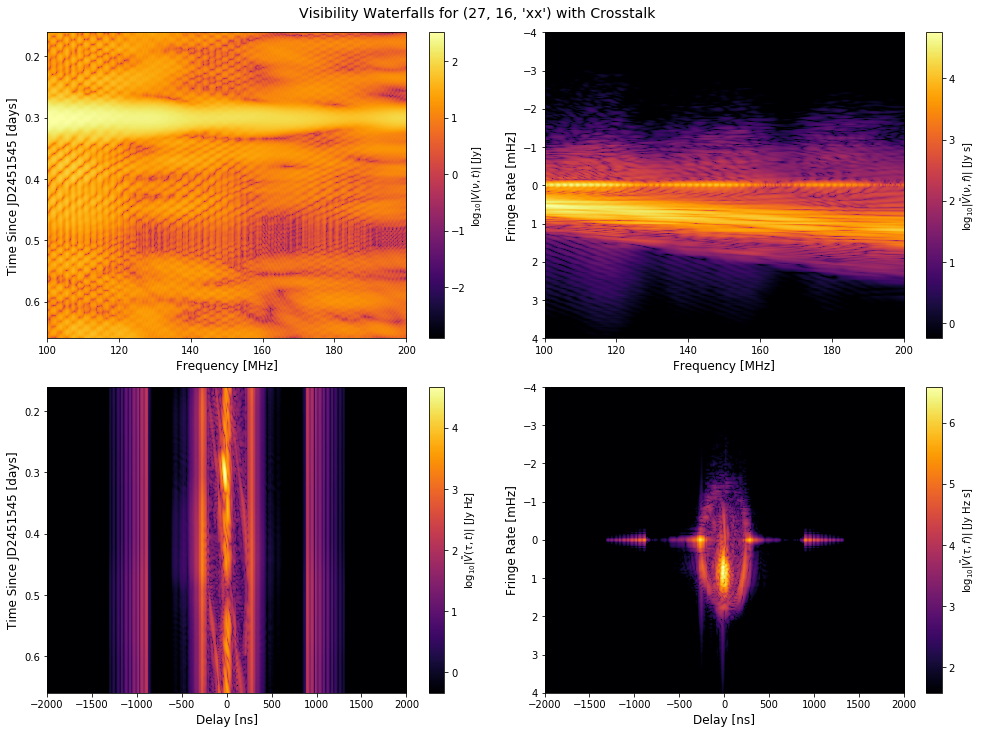

In [10]:
# plot the visibilities; 2 axes we can FT along, so 4 choices of plots

# choose what kind of taper to apply for the fringe-rate and delay transforms
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'

# get the baseline we're simulating the effect for
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]

# optionally choose to limit some of the axes
# possible choices for keys are 'freq', 'time', 'delay', and 'fringe_rate'
# values should be (min, max) for horizontal axes, (max, min) for vertical axes
plot_limits = {"delay" : (-2000, 2000), "fringe_rate" : (4, -4)}

# actually make the plots

# quick rundown of parameters:
# dynamic_range parameter is supposed to limit the dynamic range of the colorbar
# if specified, limits should be (vmax * 10**-dynamic_range, vmax)

# limit_drng parameter specifies which plots should have their dynamic range
# restricted; if one of the plot axes is in limit_drng, then the dynamic range is limited
# according to the dynamic_range parameter

# if the baseline parameter is specified, then it should be a float that specifies the 
# baseline length in meters, or an array that gives the baseline position in local coordinates
# with units of meters. if baseline is specified, then the delay plots have the geometric 
# horizon plotted as vertical lines

# horizon color specifies the color of the vertical lines that show the geometric horizon
# default is magenta, but it doesn't show up very well with the inferno colormap

# cmap and mode are passed directly to uvtools.plot.waterfall

# this function is documented; just execute `plot_waterfalls?` to see the docstring
fig = plot_waterfalls(
    xtalk_vis + crosscorr_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)

# add a title to the figure
title = "Visibility Waterfalls for %s with Crosstalk" % str(crosskey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()

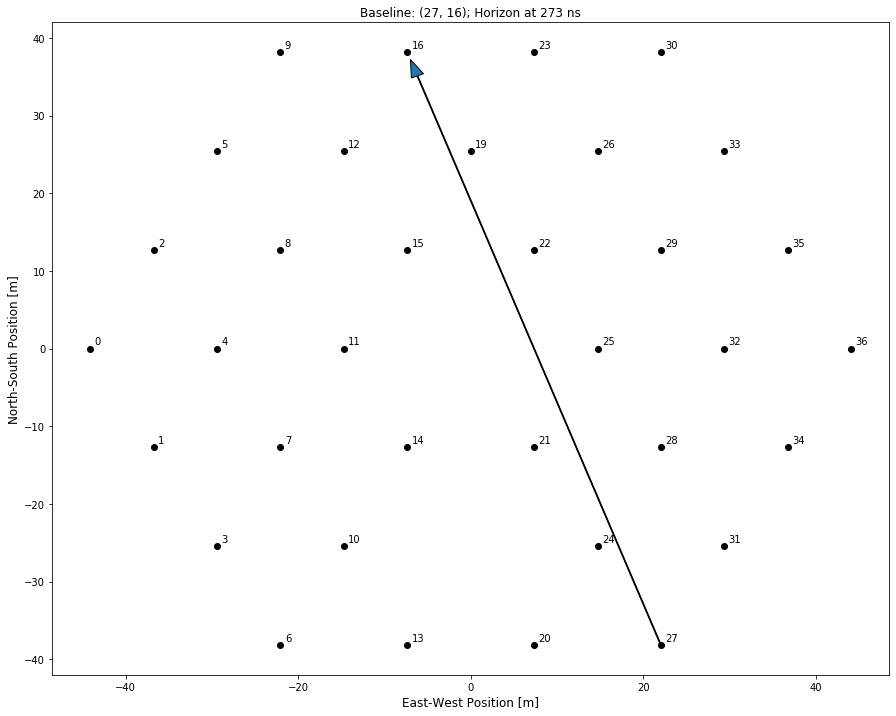

In [11]:
# plot the array and the baseline corresponding to the above plots

# offset for plotting the antenna number
ds = 0.5

# figure setup stuff
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_xlabel("East-West Position [m]", fontsize=12)
ax.set_ylabel("North-South Position [m]", fontsize=12)

# actually plot the antenna positions and label them
for ant, pos in zip(ants, antpos):
    x, y, z = pos
    ax.plot(x, y, marker='o', color='k')
    ax.text(x + ds, y + ds, ant)
    
# get parameters for plotting the baseline
xi, yi, zi = antpos[list(ants).index(crosskey[0])]
xj, yj, zj = antpos[list(ants).index(crosskey[1])]
dx = xj - xi
dy = yj - yi
dz = zj - zi

# get the geometric horizon to note in the title
horizon = np.sqrt(dx**2 + dy**2 + dz**2) / constants.c.value * 1e9

# make sure that the arrow showing the baseline looks reasonable
tail_width = 0.1
head_width = tail_width * 15
f = 0.96

# actually plot the arrow showing the baseline, as well as the title
_ = ax.arrow(xi, yi, f * dx, f * dy, width=tail_width, head_width=head_width)
_ = ax.set_title(
    "Baseline: %s; Horizon at %d ns" % (str(crosskey[:2]), horizon), fontsize=12
)

In [12]:
# experiment with cable reflections
# first, let's just do it with an autocorrelation

# choose parameters for generating cable reflections; just one per antenna
# delays and phases chosen per Nick's advice
# amplitudes chosen by looking at Fig. 4 from the data-based systematics paper
# the amplitudes are roughly appropriate for a type I signal chain
Nants = len(ants)
rdlys = np.random.uniform(1100, 1300, Nants)
rphs = np.random.uniform(0, 2*np.pi, Nants)
ramps = 10**np.random.uniform(-3, -2, Nants) # log uniform

# actually generate the reflection gains; see function documentation for details
refl_gains = hera_sim.sigchain.gen_reflection_gains(
    freqs / 1e9, ants, ramps, rdlys, rphs
)

autovis_with_refl = hera_sim.sigchain.apply_gains(autovis, refl_gains, autobl)

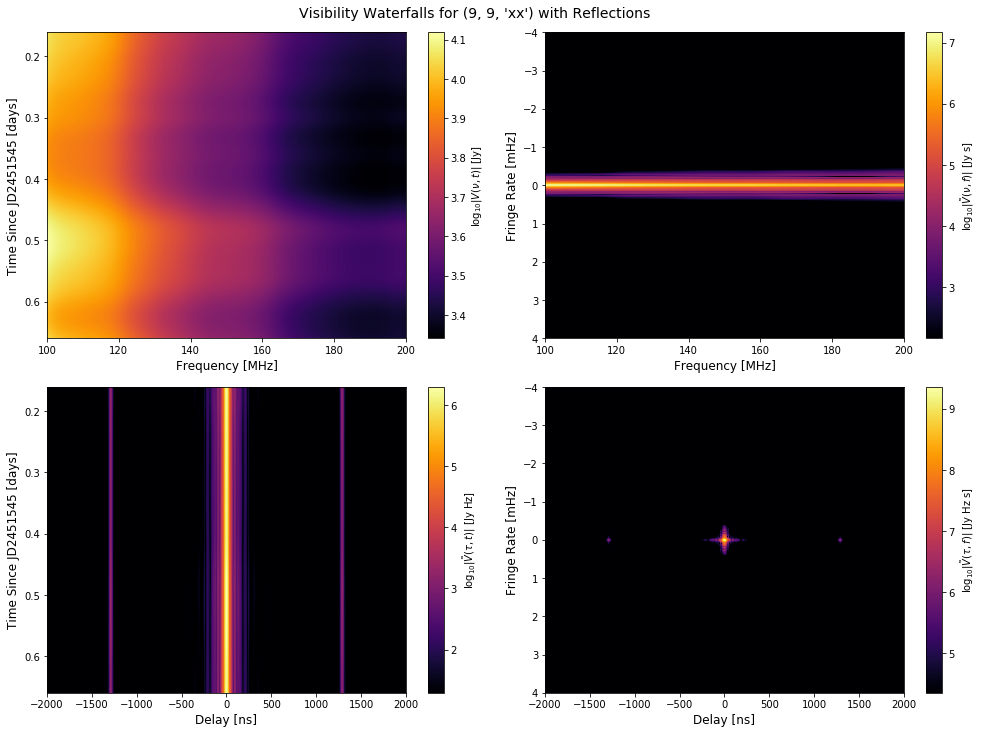

In [13]:
# check out how it looks
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'

fig = plot_waterfalls(
    autovis_with_refl, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    plot_limits=plot_limits
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Reflections" % str(autokey)
fig.text(0.3, 1, title, fontsize=14)
fig.tight_layout()

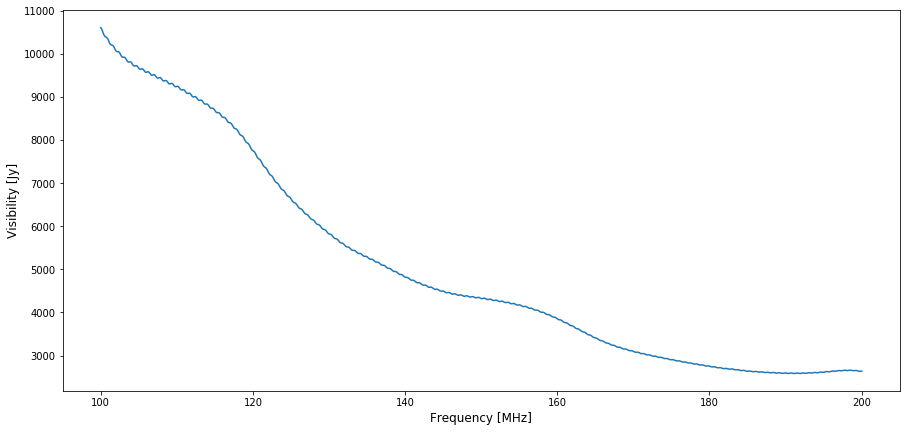

In [14]:
# look at the autocorrelation, averaged over time, with bandpass and reflection gains
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [MHz]", fontsize=12)
ax.set_ylabel("Visibility [Jy]", fontsize=12)
gain = hera_sim.sigchain.gen_gains(freqs / 1e9, [0])[0]
bandpass = np.abs(gain)**2
#bandpass = 1
_ = ax.plot(freqs / 1e6, np.abs(autovis_with_refl).mean(axis=0)) # * bandpass)

In [15]:
# check out how the data looks with crosstalk and reflections
cross_vis = uvd.get_data(crosskey)
cross_vis = hera_sim.sigchain.apply_gains(cross_vis, refl_gains, crosskey[:2])
cross_vis += xtalk_vis

Here and below, `cross_vis` contains both reflections and crosstalk

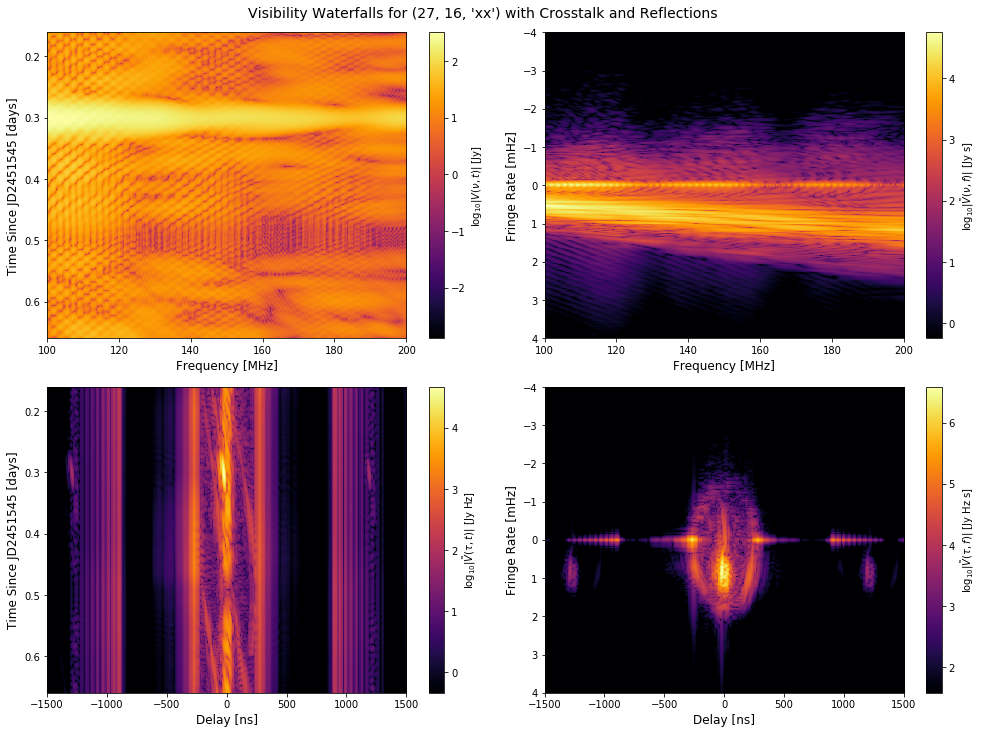

In [16]:
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}

fig = plot_waterfalls(
    cross_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits,
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk and Reflections" % str(crosskey)
fig.text(0.25, 1, title, fontsize=14)
fig.tight_layout()

In [454]:
# simulate xtalk/reflections for the whole array
# this generates crosstalk on a per-baseline basis
# the crosstalk delays/amplitudes are consistent throughout, but
# the phases are randomized
uvd_sys = copy.deepcopy(uvd)
bandpass_gains = hera_sim.sigchain.gen_gains(freqs / 1e9, ants)
use_pols = ('xx', 'yy')
for baseline in baselines:
    for pol in use_pols:
        key = baseline + (pol,)
        blt_inds, conj_blt_inds, pol_inds = uvd._key2inds(key)
        data = uvd_sys.get_data(key)
        data = hera_sim.sigchain.apply_gains(data, refl_gains, baseline)
        xtalk_vis = gen_xtalk(uvd, autovis, xamps, xdlys)
        data += xtalk_vis
        # data = hera_sim.sigchain.apply_gains(data, bandpass_gains, baseline)
        uvd_sys.data_array[blt_inds, 0, :, pol_inds[0]] = data
        if len(conj_blt_inds) != 0:
            uvd_sys.data_array[conj_blt_inds, 0, :, pol_inds[1]] = data.conj()

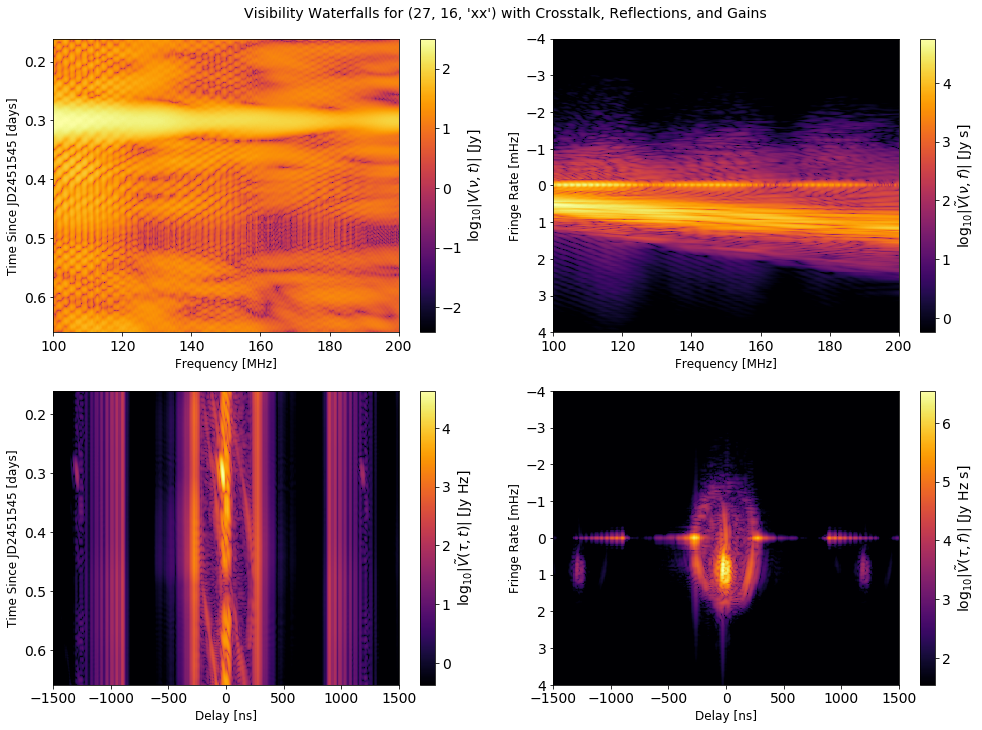

In [455]:
# let's check it out
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
baseline = antpos[list(ants).index(crosskey[0])] - antpos[list(ants).index(crosskey[1])]
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}
plot_vis = uvd_sys.get_data(crosskey)
freq_window_kwargs = {"edgecut_low" : 50, "edgecut_high" : 50}

fig = plot_waterfalls(
    plot_vis, freqs, times, windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits, freq_window_kwargs=freq_window_kwargs
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk, Reflections, and Gains" % str(crosskey)
fig.text(0.25, 1, title, fontsize=14)
fig.tight_layout()

In [ ]:
lsts_hrs = np.unique(uvd_sys.lst_array)
times_to_keep = 

In [41]:
print(vis_data_path)
print(use_files[0].split('.'))
JD_str = '.'.join(use_files[0].split('.')[3:5]) + '-' + use_files[-1].split('.')[4]
print(JD_str)
print(os.path.join(vis_data_path, 'zen.{}.xtalk_and_ref.uvh5'.format(JD_str)))
# Write corrupted vis to disk for easy access
# uvd_sys.write_uvh5(os.path.join(vis_data_path, 'zen.{}.xtalk_and_ref.uvh5'.format(JD_str)))
# Write uncorrupted vis to disk for easy access
uvd.write_uvh5(os.path.join(vis_data_path, 'zen.{}.true.uvh5'.format(JD_str)))

/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities
['/lustre/aoc/projects/hera/Validation/test-3', '2', '0/visibilities/zen', '2451545', '16100', 'RR', 'true', 'uvh5']
2451545.16100-65964
/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.2451545.16100-65964.xtalk_and_ref.uvh5


## Data Preparation

1. Create data for 0-12 hours of LST
2. Run H1C_IDR2/preprocess_data.py on data subset

**Note:** Might need to setup a UVData object wich has autos for every antenna baselines.

## Systematics Removal

The systematics removal is performed using `HERA-Team/H1C_IDR2/preprocess_data.py` and pulls all analysis parameters from the yaml file `HERA-Team/H1C_IDR2/preprocess_params.yaml`.  The parameters used here for cross talk removal (`xtalk_sub`) and reflection calibration (`ref_cal`) were pulled from

```
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2_pspec/v2/one_group/preprocess_params.yaml
```

and are representative of the current analysis parameters being used in the upcoming upper limits paper.  Those parameters, for reference, are as follows:

```
  # Xtalk Subtraction
  xtalk_sub :
    # IO
    file_ext : "X"
    Nbl_per_task : 10
    # algorithm parameters
    method : "svd-gp"  # options = ['frfilter', 'svd-gp', 'linear_filter']
    max_frate_coeffs : [0.024, -0.229]  # max_frate [mHz] = x1 * EW_bl_len [m] + x2
    # svd method parameters
    min_dly : 100
    max_dly : 4000
    horizon : 0.8
    standoff : 0
    window : 'bh'
    alpha : 0.1
    edgecut_low : [100, 400]
    edgecut_hi : [624, 150]
    gp_frate_degrade : 0.0
    gp_Nmirror : 200
    Nkeep : 30
    xthin : None
    project_vmodes : False
    frate_thresh : 0.1  # if max_frate [mHz] is below this, don't filter it
    rm_intermediate_files : False
    tol : 0.00000001

  # Reflection Calibration
  ref_cal :
    cal_ext : 'refcal.calfits'
    time_avg : True
    expand_times : True   # if time_avg, inflate gains to full time range of file
    wgt_by_nsample : False
    dly_ranges :
      - [75, 800, 3]
      - [100, 800, 5]
      - [200, 800, 5]
      - [250, 800, 5]
      - [300, 800, 5]
      - [700, 1500, 5]
    # initial guess parameters
    window : 'bh'
    alpha : 0.1
    edgecut_low : [100, 400]
    edgecut_hi : [524, 174]
    combine_spws : True
    spw_boundaries :
      - [100, 400]
      - [400, 850]  # channel boundaries when combining multispw. default is to use edgecuts.
    zeropad : 256
    Nphs : 100
    fthin : None
    ref_sig_cut : 1.0
    # refinement parameters
    opt_maxiter : 0
    opt_buffer : [15, 30]
    opt_method : 'BFGS'
    opt_tol : 0.001
    # time smoothcal parameters
    smooth_ref : True  # smooth calibration across time
    time_scale : 14400  # FWHM of Gaussian in seconds
    Nmirror : 0  # number of times to mirror time axis
    smooth_cal_ext : '_smooth'  # extension to ...{}.calfits field
```

## Power Spectrum Retrieval

Load in the datasets for the 0 - 12 hour of LST range.

In [198]:
times_to_keep = np.unique(uvd_true.time_array)[np.where(metadata_dic['lsts_hrs'] <= 11.0)[0]]

In [207]:
[list(bl) for bl in bl_subset]

[[9, 0], [9, 6], [9, 9], [27, 9], [29, 9], [31, 9], [32, 9], [34, 9], [36, 9]]

In [242]:
uvd_sys.Ntimes, uvd_true.Ntimes

(3691, 3691)

In [243]:
# uvd_sys.select(times=times_to_keep)
# uvd_true.select(times=times_to_keep)
uvd_rec.select(times=times_to_keep)

In [244]:
uvd_sys.Ntimes

3691

In [255]:
uvd_sys.write_uvh5(os.path.join(vis_data_path, "zen.0-11hrsLST.corrupt.uvh5"))
# uvd_true.write_uvh5(os.path.join(vis_data_path, "zen.0-11hrsLST.true.uvh5"))
# uvd_rec.write_uvh5(os.path.join(vis_data_path, "zen.0-11hrsLST.recovered.uvh5"))

In [247]:
# Currently only have one autocorrelation in the dataset for antenna 9
# This is the only antenna that had reflection calibration applied
bl_subset = [bl for bl in baselines if bl[0] == 9 or bl[1] == 9]

# Load in corrupted dataset
# corrupted_vis_file = 'zen.2451545.16100-65964.xtalk_and_ref.uvh5' # 0-12 hrs LST
corrupted_vis_file = 'zen.0-11hrsLST.corrupt.uvh5' # 0 - 11 hrs LST
# uvd_sys = UVData()
# uvd_sys.read(os.path.join(vis_data_path, corrupted_vis_file))

# Load in true dataset
# true_vis_file = 'zen.2451545.16100-65964.true.uvh5' # 0 - 12 hrs LST
true_vis_file = 'zen.0-11hrsLST.true.uvh5' # 0 - 11 hrs LST
# uvd_true = UVData()
# uvd_true.read(os.path.join(vis_data_path, true_vis_file),
#               bls=bl_subset)

# Load in systematics removed dataset
# recovered_vis_file = 'zen.2451545.16100-65964.xtalk_and_ref.X.uvh5' # 0 - 12 hrs LST
recovered_vis_file = 'zen.0-11hrsLST.recovered.uvh5'
uvd_rec = UVData()
uvd_rec.read(os.path.join(vis_data_path, recovered_vis_file))

Telescope RIMEz calculation is not in known_telescopes.


In [448]:
crosskey

(27, 16, 'xx')

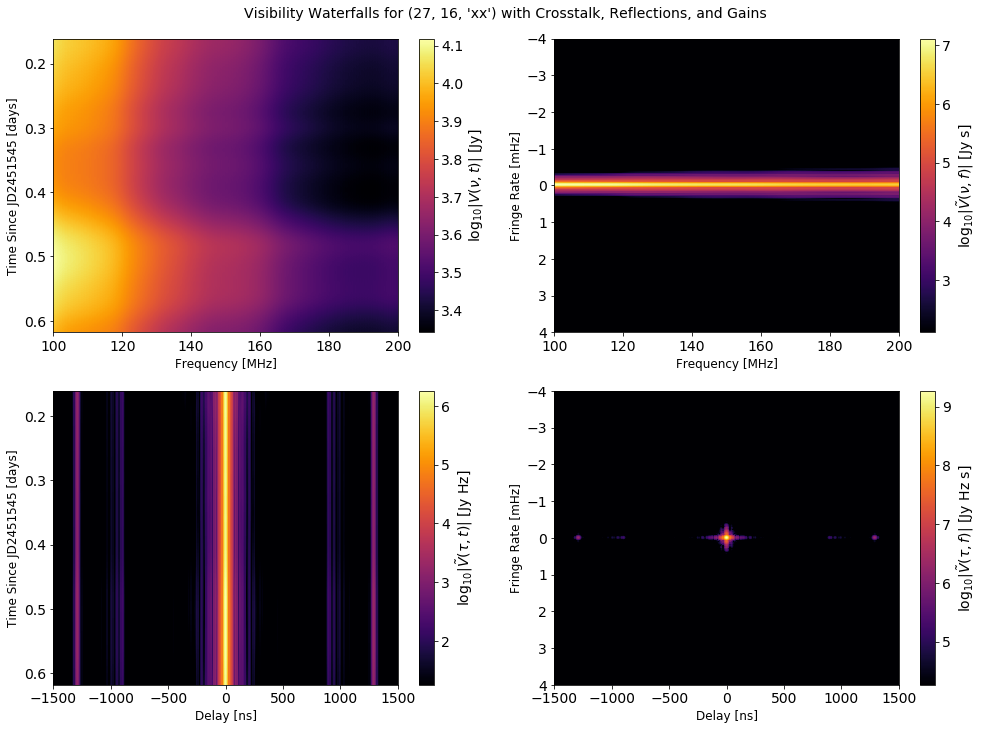

In [453]:
# let's check it out
bl_key = params['bls'][2] + ('xx',)
time_taper = 'blackman-harris'
freq_taper = 'blackman-harris'
plot_limits = {"delay" : (-1500, 1500), "fringe_rate" : (4, -4)}
plot_vis = uvd_sys.get_data(bl_key)
freq_window_kwargs = {"edgecut_low" : 50, "edgecut_high" : 50}

fig = plot_waterfalls(
    plot_vis, freqs, np.unique(uvd_sys.time_array), windows=(time_taper, freq_taper),
    dynamic_range=5, limit_drng=("delay", "fringe_rate"),
    baseline=None, horizon_color="dodgerblue", cmap='inferno',
    plot_limits=plot_limits, freq_window_kwargs=freq_window_kwargs
#    mode='phs', cmap='twilight'
)
title = "Visibility Waterfalls for %s with Crosstalk, Reflections, and Gains" % str(crosskey)
fig.text(0.25, 1, title, fontsize=14)
fig.tight_layout()

Construct dictionaries to carry around metadata and params for plotting functions.

In [271]:
metadata_dic = {}
metadata_dic['freqs'] = uvd_true.freq_array[0]
metadata_dic['lsts_hrs'] = np.unique(uvd_true.lst_array) * 12.0 / np.pi

params = {}
params['spws'] = [(175, 335), (515, 695), (705, 810)]
params['bls'] = bl_subset
params['blps'] = [(bl, bl) for bl in params['bls']]
params['edgecut_low'] = 0
params['edgecut_hi'] = 0

### hera_pspec utility functions

In [211]:
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hera_pspec.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                         Om_b=Om_b,
                                                         Om_c=Om_c,
                                                         H0=H0,)
    return hps_cosmo

# define the cosmology
cosmo = astropyPlanck15_for_hera_pspec()

# choose only the unflagged frequencies
flag_nchan_low, flag_nchan_high = (params['edgecut_low'],
                                   params['edgecut_hi'])
freq_slice = slice(flag_nchan_low, -flag_nchan_high)

# load beam-dependent normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'][()]
    Omegapp = h5f['Omegapp'][()]

Omega = {'xx': Omega, 'yy': Omega}
Omegapp = {'xx': Omegapp, 'yy': Omegapp}
    
beam = hera_pspec.pspecbeam.PSpecBeamFromArray(Omega, Omegapp,
                                               np.unique(metadata_dic['freqs']),
                                               cosmo=cosmo)

def calc_pspec(vis_file, outfile, spw_ranges=None, bls=None, polarizations=None):
    uvd = UVData()
    uvd.read(vis_file, bls=bls, polarizations=polarizations)

    if not bls is None:
        blpairs = [(bl, bl) for bl in bls]
    else:
        blpairs = None
        
    if not uvd.x_orientation is None:
        uvd.x_orientation = None
    
    if not polarizations is None:
        pol_pairs = [('xx', 'xx')]
    else:
        pol_pairs = [(pol, pol) for pol in polarizations]
    _ = hera_pspec.pspecdata.pspec_run([uvd, uvd], outfile, file_type="uvh5",
                                       taper="blackman-harris", beam=beam, cosmo=cosmo,
                                       spw_ranges=spw_ranges,
                                       blpairs=blpairs, pol_pairs=pol_pairs,
                                       Jy2mK=True, exclude_cross_bls=True, 
                                       overwrite=True, verbose=True)
    del(uvd)

def get_pspec(pspec_file, key, fold=True, avg=True, return_kparas=True, return_kperps=False):
    psc = hera_pspec.container.PSpecContainer(pspec_file, keep_open=False)
    uvp = psc.get_pspec(psc.groups()[0])[0]
    if fold:
        uvp.fold_spectra()
    pspec = uvp.get_data(key)
    if avg:
        pspec = pspec.mean(axis=0)
    output = [pspec,]
    if return_kparas:
        output.append(uvp.get_kparas(key[0]))
    if return_kperps:
        output.append(uvp.get_kperps(key[0]))
    return output

def extract_power_spectra(pspec_files, signal_types, bls, spws, avg=False):
    ps = {}
    for i_spw, spw in enumerate(spws):
        blp_dic = {}
        for bl in bls:
            key = (i_spw, (bl, bl), 'xx')
            lbl_dic = {}
            for lbl in signal_types:
                lbl_inds = [lbl in fn for fn in pspec_files]
                data_dic = {}
                spectra = []
                kparas = []
                for pspec_file in np.array(pspec_files)[lbl_inds]:
                    output = get_pspec(pspec_file, key, avg=avg)
                    spectra.append(output[0])
                    kparas.append(output[1])
                data_dic['data'] = np.array(spectra)
                data_dic['kpara'] = np.array(kparas)
                lbl_dic[lbl] = data_dic
            blp_dic[bl] = lbl_dic
        ps[spw] = blp_dic
    return ps

In [260]:
signal_types = ['true', 'corrupt', 'recovered']
vis_files = [os.path.join(vis_data_path, true_vis_file),
             os.path.join(vis_data_path, corrupted_vis_file),
             os.path.join(vis_data_path, recovered_vis_file)]
calc_ps = False

print('Visibility Files:\n' + '-'*17)
for fn in vis_files:
    print(fn)
    
if len(params['spws']) == 1:
    pspec_files = [fn.replace('.uvh5', '.spw_{}-{}.psc'.format(params['spws'][0][0],
                                                               params['spws'][0][1]))
                   for fn in vis_files]
else:
    pspec_files = [fn.replace('.uvh5', '.{}_spws.psc'.format(len(params['spws']))) for fn in vis_files]
pspec_files = [fn.replace('visibilities', 'pspec') for fn in pspec_files]
pspec_files[1] = pspec_files[1].replace('xtalk_and_ref', 'corrupt')
pspec_files[2] = pspec_files[2].replace('xtalk_and_ref.X', 'recovered')
print('\nPspec Files:\n' + '-'*12)
for fn in pspec_files:
    print(fn, end='\n\n')
    
if calc_ps:
    for vis_file, pspec_file in zip(vis_files[1:2], pspec_files[1:2]):
        print("Extracting spectrum from {}".format(os.path.basename(vis_file)))
        calc_pspec(vis_file, pspec_file, spw_ranges=params['spws'], bls=params['bls'], polarizations=['xx'])

ps = extract_power_spectra(pspec_files, signal_types, params['bls'], params['spws'])

Visibility Files:
-----------------
/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.0-11hrsLST.true.uvh5
/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.0-11hrsLST.corrupt.uvh5
/lustre/aoc/projects/hera/Validation/test-3.2.0/visibilities/zen.0-11hrsLST.recovered.uvh5

Pspec Files:
------------
/lustre/aoc/projects/hera/Validation/test-3.2.0/pspec/zen.0-11hrsLST.true.3_spws.psc

/lustre/aoc/projects/hera/Validation/test-3.2.0/pspec/zen.0-11hrsLST.corrupt.3_spws.psc

/lustre/aoc/projects/hera/Validation/test-3.2.0/pspec/zen.0-11hrsLST.recovered.3_spws.psc



In [317]:
uvps = {}
uvps_avg = {}
keys = ['true', 'corrupt', 'recovered']
for key, pspec_file in zip(keys, pspec_files):
    psc = hera_pspec.PSpecContainer(pspec_file, keep_open=False)
    uvps[key] = psc.get_pspec('dset0_dset1', 'dset0_x_dset1')
    uvps_avg[key] = copy.deepcopy(uvps[key])
    uvps_avg[key].average_spectra(time_avg=True)

In [318]:
print(uvps['true'].get_data((0, params['blps'][0], 'xx')).shape)
print(uvps['true'].get_kparas(0).shape)

(3691, 160)
(160,)


In [346]:
def plot_pspec_waterfalls(bl, uvps, params, metadata_dic):
    
    freqs = metadata_dic['freqs']
    lsts_hrs = metadata_dic['lsts_hrs']
    spws = params['spws']
    nspws = len(spws)
    ntimes = lsts_hrs.size

    nrows = nspws
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4 * nrows))
    axs = np.array(axs)

    for ax in axs[:, 0]:
        ax.set_ylabel('LST [hrs]')

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw, spw in enumerate(params['spws']):
            kparas = uvps['true'].get_kparas(i_spw)
            nkmodes = kparas.squeeze().size
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            delays = kparas / tau_to_kpara * 1.0e9
            delays_xlim = [delays.min(), delays.max()]
            extent = [delays.min(), delays.max(),
                      lsts_hrs.max(), lsts_hrs.min()]

            # Plot flags for spw
            ax = axs[i_spw, 0]
            cax = ax.imshow(np.log10(uvps['true'].get_data((i_spw, (bl, bl), 'xx')).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('True')
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, 'spw = {}'.format(spw), transform=ax.transAxes,
                    fontsize=14, verticalalignment='top', horizontalalignment='left', bbox=props)

            ax = axs[i_spw, 1]
            cax = ax.imshow(np.log10(uvps['corrupt'].get_data((i_spw, (bl, bl), 'xx')).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('Corrupt')

            ax = axs[i_spw, 2]
            cax = ax.imshow(np.log10(uvps['recovered'].get_data((i_spw, (bl, bl), 'xx')).real),
                            aspect='auto', extent=extent)
            fig.colorbar(cax, ax=ax, label=r'Re[$P(k)$] [mK$^2$ Mpc$^3$]')
            if i_spw == 0: ax.set_title('Recovered')

            for ax in axs[i_spw]:
                if i_spw == nspws - 1: ax.set_xlabel(r'$\tau$ [ns]')
                ax.set_xlim(delays_xlim)
                # Twin axis for plotting kparallels
                ax2 = plt.twiny(ax)
                ax2.set_xlim(delays_xlim)
                ax2.set_xticklabels([np.round(dly * tau_to_kpara / 1.0e9, decimals=1)
                                     for dly in ax2.get_xticks()])
                if i_spw == 0: ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Delay Power Spectra for Baseline Key {}'.format(bl), fontsize=14)

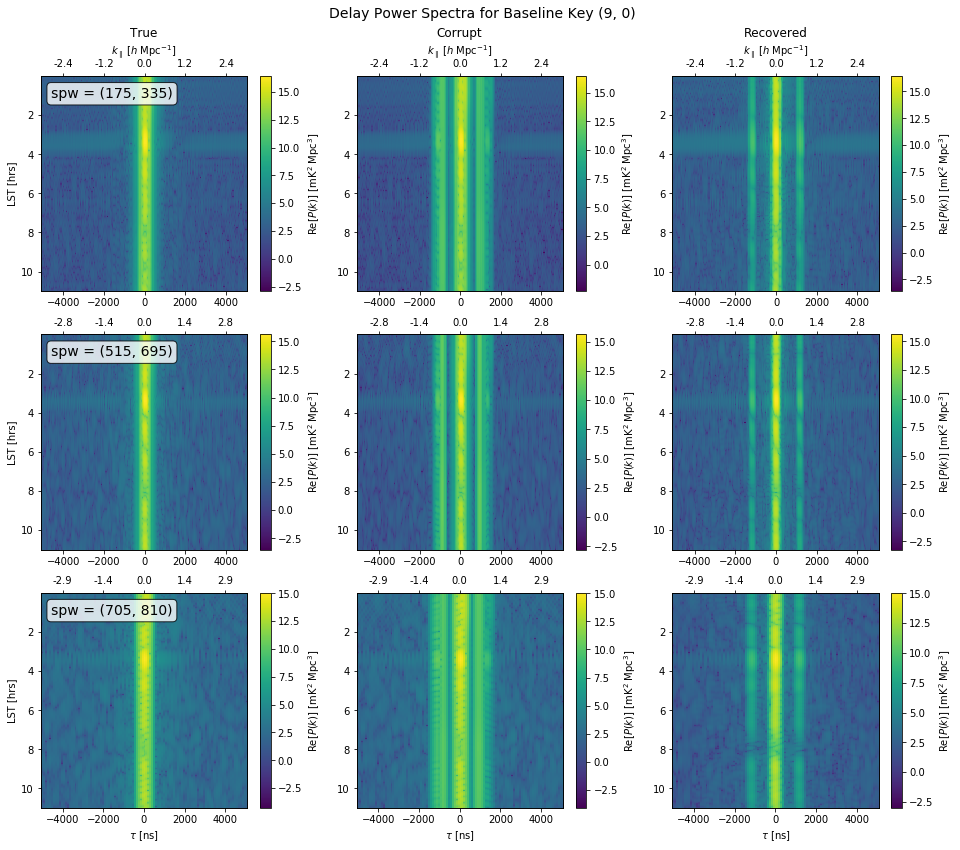

In [347]:
bl = params['bls'][0]
plot_pspec_waterfalls(bl, uvps, params, metadata_dic)

In [304]:
from matplotlib.gridspec import GridSpec

In [445]:
def plot_time_averaged_pspec_spectra(bl, uvps, params, metadata_dic, ylims=None, max_delay=None):
    
    lsts_hrs = metadata_dic['lsts_hrs']
    freqs = metadata_dic['freqs']
    spws = params['spws']
    ntimes = lsts_hrs.size
    nspws = len(spws)
    
    if not ylims is None and len(ylims) == 1 and nspws > 1:
        ylims = [ylims[0] for _ in range(nspws)]

    fig = plt.figure(figsize=(13.5, 3 * nspws))
    gs = GridSpec(2, nspws)
    
    labels = ['true', 'corrupt', 'recovered']

    with np.errstate(divide='ignore', invalid='ignore'):
        for i_spw, spw in enumerate(spws):
            kparas = uvps['true'].get_kparas(i_spw)
            kparas_xlim = [kparas[0], kparas[-1]]
            redshift = cosmo.f2z(freqs[spw[0]:spw[1]].mean())
            tau_to_kpara = cosmo.tau_to_kpara(redshift)
            delays = kparas / tau_to_kpara * 1.0e9
            if max_delay is None:
                delays_xlim = [delays.min(), delays.max()]
            else:
                delays_xlim = [-max_delay, max_delay]

            # power spectra
            ax = fig.add_subplot(gs[0, i_spw])
            for i, lbl in enumerate(labels):
                ax.plot(delays,
                        uvps[lbl].get_data((i_spw, (bl, bl), 'xx'))[0],
                        label=lbl)
            ax.legend(loc='upper right')
            ax.set_xlim(delays_xlim)
            ax.set_xticklabels([])
            ax.set_yscale('log')
            if i_spw == 0: ax.set_ylabel(r'Re($P(k)$) [mK$^2$ h$^{-3}$ Mpc$^3$]')
            ax.set_title('spw = {}'.format(spw))
            
            ax2 = plt.twiny(ax)
            ax2.set_xlim(delays_xlim)
            ax2.set_xticklabels([np.round(dly * tau_to_kpara / 1.0e9, decimals=1)
                                 for dly in ax2.get_xticks()])
            ax2.set_xlabel(r'$k_{\parallel}$ [$h$ Mpc$^{-1}$]')
            
            # fractional difference
            recovered_ps = uvps['recovered'].get_data((i_spw, (bl, bl), 'xx'))[0]
            true_ps = uvps['true'].get_data((i_spw, (bl, bl), 'xx'))[0]

            # frac_diff = (recovered_ps - true_ps) / true_ps
            ratio = recovered_ps.real / true_ps.real

            ax = fig.add_subplot(gs[1, i_spw])
            ax.plot(delays, ratio, lw=2)
            if i_spw == 0: ax.set_ylabel(r'Re(recovered) / Re(true)')
            ax.hlines(1.0, *delays_xlim, linestyle='--', color='k')
            ax.set_xlim(delays_xlim)
            ax.set_yscale('log')
            
            # ax.grid(axis='both', which='both', alpha=0.25, color='k')
            if i_spw == nspws - 1:
                ax.set_xlabel(r'$\tau$ [ns]')

        gs.tight_layout(fig)
        gs.update(top = 0.85, hspace=0.05)
        fig.suptitle('Delay Power Spectra for Baseline {}'.format(bl))

In [432]:
ants_subset = np.unique([ant for bl in params['bls'] for ant in bl])
print(ants_subset)
use_inds = [np.where(antnums == antnum)[0][0] for antnum in ants_subset]
print(use_inds)

[ 0  6  9 27 29 31 32 34 36]
[0, 6, 9, 25, 27, 29, 30, 32, 34]


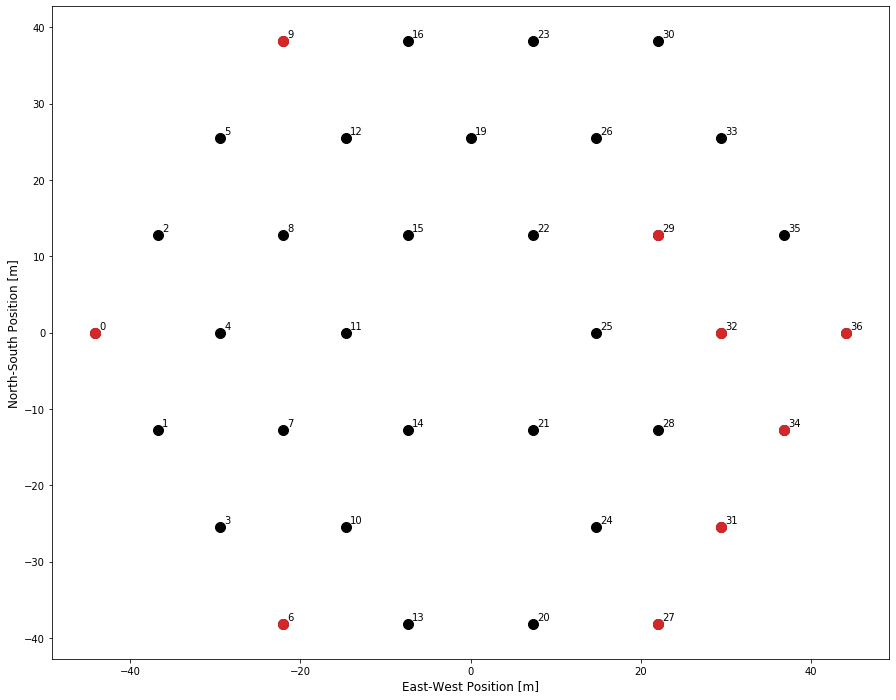

In [437]:
# plot the array and the baseline corresponding to the above plots

# offset for plotting the antenna number
ds = 0.5

# figure setup stuff
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_xlabel("East-West Position [m]", fontsize=12)
ax.set_ylabel("North-South Position [m]", fontsize=12)

# actually plot the antenna positions and label them
for ant, pos in zip(ants, antpos):
    x, y, z = pos
    ax.scatter(x, y, marker='o', s=100, color='k')
    ax.text(x + ds, y + ds, ant)
    
poss, antnums = uvd_true.get_ENU_antpos()
for (x, y, z) in poss[use_inds]:
    ax.scatter(x, y, marker='o', s=100, color='C3')

In [413]:
for bl in params['bls']:
    blid = uvd_true.antnums_to_baseline(*bl)
    uvw = uvd_true.uvw_array[np.where(uvd_true.baseline_array == blid)[0][0]]
    bl_length = np.sqrt(np.sum(uvw**2))
    bl_angle = np.arctan2(uvw[1], uvw[0]) * 180 / np.pi
    print(bl, bl_length, bl_angle)

(9, 0) 44.099999982853 -120.00000001304926
(9, 6) 76.3834405738902 -90.00000000021744
(9, 9) 0.0 0.0
(27, 9) 88.19999996514952 120.00000001282311
(29, 9) 50.92229376004111 149.9999999650956
(31, 9) 81.84613614540513 128.94827555773634
(32, 9) 64.07581445802617 143.41322446062568
(34, 9) 77.78508849531893 139.10660539304112
(36, 9) 76.38344060351977 150.00000001303184


In [400]:
params['bls']

[(9, 0), (9, 6), (9, 9), (27, 9), (29, 9), (31, 9), (32, 9), (34, 9), (36, 9)]

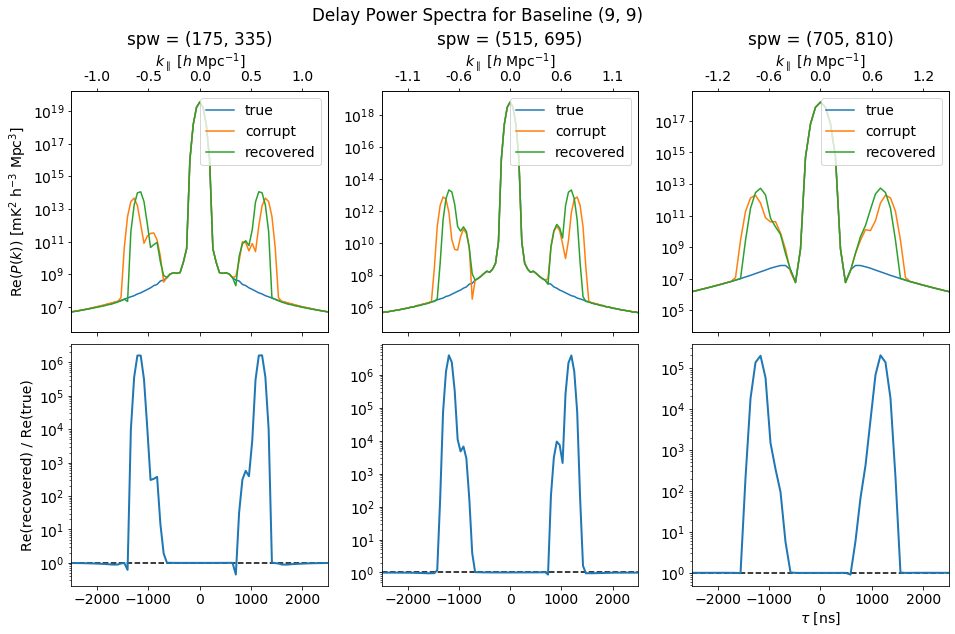

In [447]:
bl = params['bls'][2]
plot_time_averaged_pspec_spectra(bl, uvps_avg, params, metadata_dic, max_delay=2500)

## Extension to Full Day/Array

Do we want to extend this to a full day's worth of data? What about for a fully inflated array?